In [45]:
import numpy as np 
np.random.seed(102) 

# Breast ultrasound tumour classification: A Machine Learning—Radiomics based approach

In [46]:
import cv2
from PIL import Image
import os
from skimage.feature.texture import graycomatrix, graycoprops
from skimage.measure import shannon_entropy
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import warnings

warnings.filterwarnings("ignore")

# Constants
SIZE = 224
image_directory = r"D:\Desktop\nouran\SBME\SBME 3.2\ML\Project\trial 2\Dataset_BUSI_with_GT\\"

# Function to load and preprocess data
def load_and_preprocess(image_folder, label_value, size=SIZE):
    mask_folder = image_folder
    images = [img for img in os.listdir(image_directory + image_folder) if "mask" not in img]
    masks = [mask for mask in os.listdir(image_directory + mask_folder) if "mask" in mask]
    dataset = []
    labels = []
    for image_name, mask_name in zip(images, masks):
        image = cv2.imread(image_directory + image_folder + image_name, 0)
        mask = cv2.imread(image_directory + mask_folder + mask_name, 0)
        if image is not None and mask is not None:
            # Resize the mask to match the image
            mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

            # Create an RGB image
            rgb_image = np.zeros((image.shape[0], image.shape[1], 3))
            rgb_image[:, :, 0] = image
            rgb_image[:, :, 1] = mask
            rgb_image[:, :, 2] = cv2.bitwise_and(image, mask)

            # Normalization
            rgb_image = rgb_image / 255

            # Resize the RGB image
            rgb_image = Image.fromarray((rgb_image * 255).astype(np.uint8)).resize((size, size))

            dataset.append(extract_features(np.array(rgb_image)))
            
            labels.append(label_value)
    return np.array(dataset), np.array(labels)



# Function to extract features
def extract_features(image):
    # Convert image to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Shape features
    moments = cv2.moments(image)
    hu_moments = cv2.HuMoments(moments).ravel()

    # Texture features
    glcm = graycomatrix(image, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4])
    contrast = graycoprops(glcm, 'contrast').ravel()
    dissimilarity = graycoprops(glcm, 'dissimilarity').ravel()
    homogeneity = graycoprops(glcm, 'homogeneity').ravel()
    energy = graycoprops(glcm, 'energy').ravel()
    correlation = graycoprops(glcm, 'correlation').ravel()
    ASM = graycoprops(glcm, 'ASM').ravel()

    # Edge features
    edges = cv2.Canny(image,100,200)
    entropy = np.array([shannon_entropy(edges)])

    # Concatenate all features into a single array
    features = np.hstack([hu_moments, contrast, dissimilarity, homogeneity, energy, correlation, ASM, entropy])
    

    return features




# Load dataset
normal_images, normal_labels = load_and_preprocess('normal\\', 0)
benign_images, benign_labels = load_and_preprocess('benign\\', 1)
malignant_images, malignant_labels = load_and_preprocess('malignant\\', 2)




In [47]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.feature_selection import RFE

# Concatenate data
X = np.concatenate([ benign_images, malignant_images], axis=0)
y = np.concatenate([ benign_labels, malignant_labels], axis=0) -1 # encoding benign, malignant labels from (1,2) to (0,1)
# Split the original data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply RFE on the training data
estimator = GradientBoostingClassifier(random_state=42)
selector = RFE(estimator, n_features_to_select=10, step=1)
X_train_rfe = selector.fit_transform(X_train, y_train)

# Apply SMOTE only on the RFE transformed training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_rfe, y_train)

# Train the model on the resampled training data
clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_res, y_train_res)

# Make sure to transform the test set as well before making predictions
X_test_rfe = selector.transform(X_test)
y_pred = clf.predict(X_test_rfe)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print the accuracy score
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

# Print the F1 score
print("F1 Score:")
print(f1_score(y_test, y_pred, average='weighted'))

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.90       141
           1       0.71      0.78      0.74        54

    accuracy                           0.85       195
   macro avg       0.81      0.83      0.82       195
weighted avg       0.86      0.85      0.85       195

Accuracy Score:
0.8512820512820513
F1 Score:
0.8532300516326586


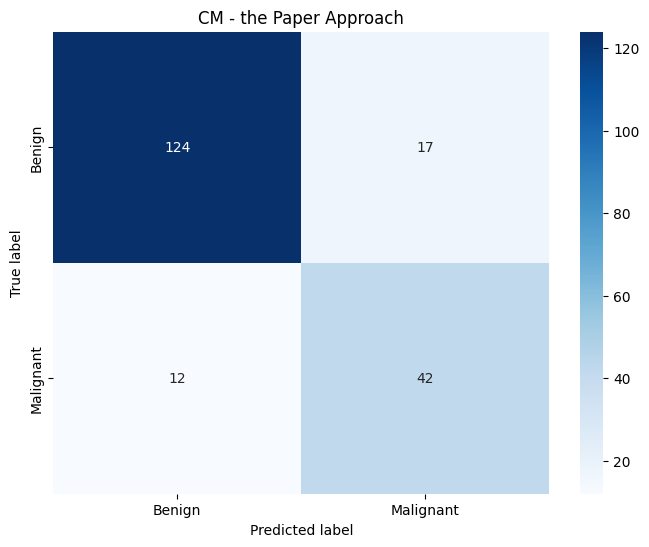

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the class names
class_names = ['Benign', 'Malignant']  

def plot_confusion_matrix(cm, title, classes = class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix with class names
plot_confusion_matrix(cm, title= 'CM - the Paper Approach')



## Our trial using their approach, changing test size to 0.1 and creating a 5-dimensional representation of the data

In [49]:

# Split the original data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Apply RFE on the training data
estimator = GradientBoostingClassifier(random_state=42)
selector = RFE(estimator, n_features_to_select=5, step=1)
X_train_rfe = selector.fit_transform(X_train, y_train)

# Apply SMOTE only on the RFE transformed training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_rfe, y_train)

# Train the model on the resampled training data
clf = GradientBoostingClassifier(n_estimators=200, random_state=42)
clf.fit(X_train_res, y_train_res)

# Make sure to transform the test set as well before making predictions
X_test_rfe = selector.transform(X_test)
y_pred_2 = clf.predict(X_test_rfe)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_2))

# Print the accuracy score
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred_2))

# Print the F1 score
print("F1 Score:")
print(f1_score(y_test, y_pred_2, average='weighted'))

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95        48
           1       0.88      0.82      0.85        17

    accuracy                           0.92        65
   macro avg       0.91      0.89      0.90        65
weighted avg       0.92      0.92      0.92        65

Accuracy Score:
0.9230769230769231
F1 Score:
0.9223079326172109


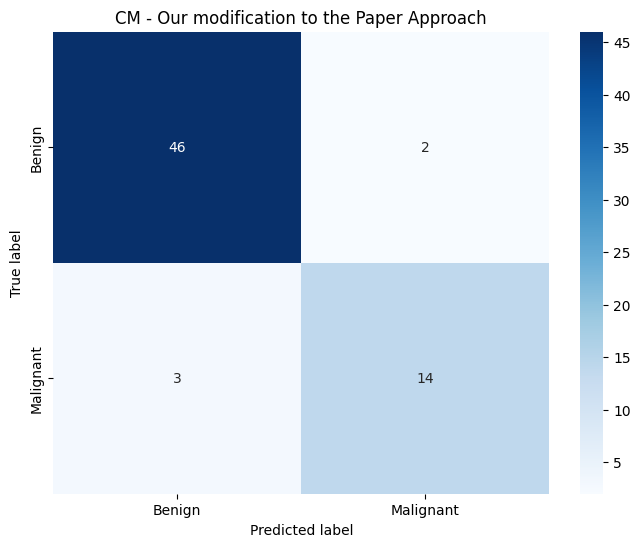

In [50]:
# Get the confusion matrix
cm_2 = confusion_matrix(y_test, y_pred_2)

# Plot the confusion matrix
plot_confusion_matrix(cm_2, title='CM - Our modification to the Paper Approach')